# Minimum Weight Perfect Matching

Here we will impelement the Minimum Weight Perfect Matching decoder for the surface code with a depolarizing noise model.

In [92]:
from typing import Tuple, Dict, List
import re
import numpy as np
import networkx as nx

In [78]:
class ErrorModel:
    """This class encodes an uncorrelated error model with different probabilities of X, Y, and Z errors."""

    def __init__(self, model_dict: Dict[int, Tuple[float, float, float]]):
        """The error model can be represented by a dictionary mapping qubit indices,
        which are integers, to a tuple of three floats, those being the probabilities
        of X, Y, and Z errors."""

        self._dict = model_dict
    
    @property
    def nqubits(self):
        return len(self._dict.keys())
    
    def uniform(nqubits: int, px: float, py: float, pz: float):
        """A model where every qubit has the same error probabilities."""

        assert px >= 0
        assert py >= 0
        assert pz >= 0
        assert px + py + pz <= 1.0, "Probabilites of X, Y, and Z errors cannot be greater than 1."
        
        dict = {q: (px, py, pz) for q in range(nqubits)}
        return ErrorModel(dict)

    def depolarizing(nqubits: int, lamb: float):
        """A uniform depolarizing model on each qubit."""

        return ErrorModel.uniform(nqubits, lamb / 3., lamb / 3., lamb / 3.)
    
    def sample(self):
        """Sample a binary-symplectic Pauli string from the error model."""

        raise NotImplementedError()

In [79]:
error_model = ErrorModel.uniform(10, 0.1, 0.2, 0.1)

In [82]:
def surface_code_tanner_graphs(d: int) -> Tuple[nx.Graph, nx.Graph]:
    """Get the X and Z check Tanner graphs for the rotated surface code."""

    x_graph = nx.Graph()
    z_graph = nx.Graph()
    # For the data qubits, we number them first by rows, then by columns. E.g. for d=3
    # 0 1 2
    # 3 4 5
    # 6 7 8
    # For measure qubits, we first number the "inner" 4-body chekcs.
    # Then we number the top, bottom, left, and right checks, e.g.
    # * * 4 *
    # 6 0 1 *
    # * 2 3 7
    # * 5 * *
    # where * denotes that there is no check there. On this chart, checks
    # 4, 0, 3, and 5 are all X checks, and checks 6, 1, 2, and 7 are Z checks.
    # Add nodes for the data qubits.
    for i in range(d ** 2):
        x_graph.add_node(f"q{i}")
        z_graph.add_node(f"q{i}")
    # Add nodes for the check qubits.
    num_checks = (d - 1) ** 2 + 2 * (d - 1) # Number of checks for both X or Z
    for i in range(num_checks):
        x_graph.add_node(f"s{i}")
        z_graph.add_node(f"s{i}")
    
    # Four-body checks.
    for i in range(d - 1): # Rows of the lattice of plaquettes
        if i % 2 == 0:
            is_x_check = True
        else:
            is_x_check = False
        for j in range(d - 1): # Columns of the lattice of plaquettes
            stabilizer = f"s{i * (d-1) + j}"
            if is_x_check:
                x_graph.add_edge(f"q{i * d + j}", stabilizer)
                x_graph.add_edge(f"q{i * d + j + 1}", stabilizer)
                x_graph.add_edge(f"q{(i + 1) * d + j}", stabilizer)
                x_graph.add_edge(f"q{(i + 1) * d + j + 1}", stabilizer)
            else:
                z_graph.add_edge(f"q{i * d + j}", stabilizer)
                z_graph.add_edge(f"q{i * d + j + 1}", stabilizer)
                z_graph.add_edge(f"q{(i + 1) * d + j}", stabilizer)
                z_graph.add_edge(f"q{(i + 1) * d + j + 1}", stabilizer)
            is_x_check = not is_x_check
    
    k = (d - 1) ** 2 # Index of two-body check.
    if d % 2 == 0:
        two_body_checks_per_side = d // 2
    else:
        two_body_checks_per_side = (d - 1) // 2
    # X checks at the top of the lattice
    i = 0 # Data qubit row index
    j = 1 # Data qubit column index
    for _ in range(two_body_checks_per_side):
        x_graph.add_edge(f"q{i * d + j}", f"s{k}")
        x_graph.add_edge(f"q{i * d + j + 1}", f"s{k}")
        k += 1
        j += 2
    # X checks at the bottom of the lattice
    i = d - 1 # Data qubit column index
    j = 0 # Data qubit row index
    for _ in range(two_body_checks_per_side):
        x_graph.add_edge(f"q{i * d + j}", f"s{k}")
        x_graph.add_edge(f"q{i * d + j + 1}", f"s{k}")
        k += 1
        j += 2
    # Z checks to the left of the lattice
    i = 0 # Data qubit column index
    j = 0 # Data qubit row index
    for _ in range(two_body_checks_per_side):
        z_graph.add_edge(f"q{i * d + j}", f"s{k}")
        z_graph.add_edge(f"q{(i + 1) * d + j}", f"s{k}")
        k += 1
        i += 2
    # Z checks to the right of the lattice
    i = 1 # Data qubit column index
    j = d - 1 # Data qubit row index
    for _ in range(two_body_checks_per_side):
        z_graph.add_edge(f"q{i * d + j}", f"s{k}")
        z_graph.add_edge(f"q{(i + 1) * d + j}", f"s{k}")
        k += 1
        i += 2

    # Some stabilizers are not involved in the X or Z graphs.
    # Remove them.
    x_graph.remove_nodes_from(list(nx.isolates(x_graph)))
    z_graph.remove_nodes_from(list(nx.isolates(z_graph)))
    return (x_graph, z_graph)

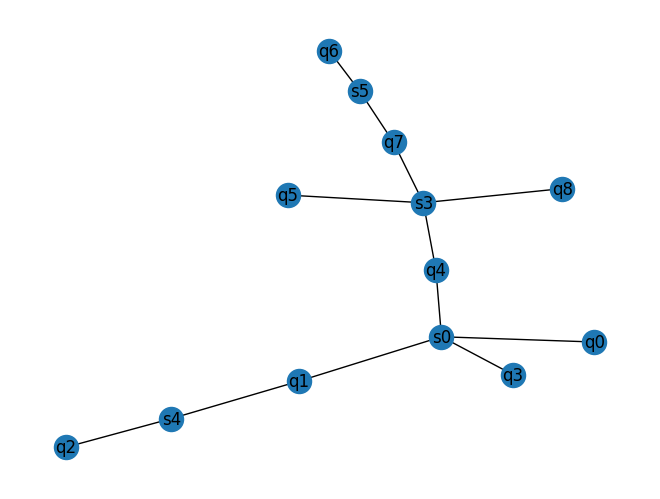

In [83]:
x_graph, z_graph = surface_code_tanner_graphs(3)
nx.draw(x_graph, with_labels=True)

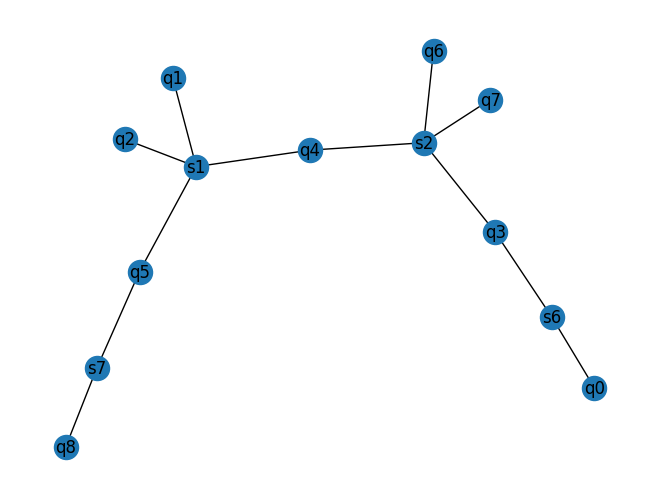

In [84]:
nx.draw(z_graph, with_labels=True)

In [111]:
def error_to_syndrome(err: np.ndarray, graph: nx.Graph) -> List[str]:
    """Map an error (either the X or Z part of a binary symplectic vector) to a syndrome
    (represented as a map from syndrome node names on the Tanner graph to booleans)."""

    syndrome_nodes = [n for n in graph.nodes if 's' in n]
    syndrome: List[str] = []
    for s in syndrome_nodes:
        num_neighbors_true = 0
        for nn in graph.neighbors(s):
            idx = int(re.search(r'\d+', nn).group()) 
            if err[idx]:
                num_neighbors_true += 1
        if num_neighbors_true % 2 != 0:
            syndrome.append(s)
    return syndrome

In [112]:
for i in range(9):
    err = np.zeros(9, dtype=bool)
    err[i] = True
    syndrome = error_to_syndrome(err, x_graph)
    print(i, syndrome)

0 ['s0']
1 ['s0', 's4']
2 ['s4']
3 ['s0']
4 ['s0', 's3']
5 ['s3']
6 ['s5']
7 ['s3', 's5']
8 ['s3']


In [113]:
for i in range(9):
    err = np.zeros(9, dtype=bool)
    err[i] = True
    syndrome = error_to_syndrome(err, z_graph)
    print(i, syndrome)

0 ['s6']
1 ['s1']
2 ['s1']
3 ['s2', 's6']
4 ['s1', 's2']
5 ['s1', 's7']
6 ['s2']
7 ['s2']
8 ['s7']
